In [ ]:
#Import the relevant packages:
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt

%matplotlib inline
import torch.nn as nn
from torch import optim

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision

from torchvision import transforms, models, datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os

import cv2

In [ ]:
# upload our Kaggle authentication file
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download the cats and dogs dataset and unzip it
! kaggle datasets download jangedoo/utkface-new

 93% 309M/331M [00:02<00:00, 236MB/s]
100% 331M/331M [00:02<00:00, 153MB/s]


In [ ]:
! unzip utkface-new.zip

In [ ]:
path = "/content/utkface_aligned_cropped/UTKFace"

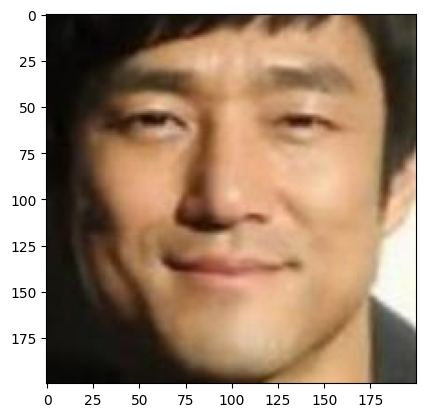

In [ ]:
img = cv2.imread("/content/utkface_aligned_cropped/UTKFace/35_0_2_20170116172822574.jpg.chip.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
#loop through file and create list of images feature
images=[]
ages=[]
gender=[]

for file in files:

    images.append(file)
    imgname = file.split("_")

    ages.append(int(imgname[0]))
    gender.append(int(imgname[1]))

In [ ]:
#creat dataframe
df = pd.DataFrame({"images": images , "ages":ages , "gender":gender } )
df.head()

,images,ages,gender
0,44_0_3_20170119204716767.jpg.chip.jpg,44,0
1,26_1_3_20170117174603671.jpg.chip.jpg,26,1
2,2_1_3_20161220144550221.jpg.chip.jpg,2,1
3,75_0_0_20170111210708463.jpg.chip.jpg,75,0
4,8_0_0_20170110220038315.jpg.chip.jpg,8,0


In [ ]:

from torch.utils.data import Dataset, DataLoader
import cv2
IMAGE_SIZE = 224

class GenderAgeClass(Dataset):
    def __init__(self, df):

        self.df = df
        self.transform =  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#         self.transform = transforms.Compose([

#         transforms.RandomResizedCrop(size=(224, 224)),
#         transforms.RandomHorizontalFlip(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])
    def __len__(self): return len(self.df)

    def __getitem__(self, ix):

        f = self.df.iloc[ix]
        images =f.images
        gen = f.gender
        age = f.ages
        im = cv2.imread("/content/utkface_aligned_cropped/UTKFace/" + images)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        return im, age, gen

    def preprocess_image(self, im):

        im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
        im = torch.tensor(im).permute(2,0,1)
        im = self.transform(im/255)
        return im[None]

    def collate_fn(self, batch):

        'preprocess images, ages and genders'
        ims, ages, genders = [], [], []
        for im, age, gender in batch:

            im = self.preprocess_image(im)
            ims.append(im)

            ages.append(float(int(age)/116))
            genders.append(float(gender))

        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        ims = torch.cat(ims).to(device)

        return ims, ages, genders

In [ ]:
trn_df=df.sample(frac=1,random_state=0).iloc[:15000]
val_df=df.sample(frac=1,random_state=0).iloc[15000:]

In [ ]:
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)

In [ ]:
#creat dataloader from dataset
train_loader = DataLoader(trn, batch_size=32, shuffle=True, drop_last=True, collate_fn=trn.collate_fn)
test_loader = DataLoader(val, batch_size=32, collate_fn=val.collate_fn)

In [ ]:
# Define a model, loss function, and optimizer
def get_model():

    model = models.resnet50(pretrained = True)
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    # model.avgpool = nn.Sequential(
    #     nn.Conv2d(2048,2048, kernel_size=3),
    #     nn.MaxPool2d(2),
    #     nn.ReLU(),
    #     nn.Flatten()
    #)
    model.avgpool = nn.AdaptiveAvgPool2d(2,2)

    class ageGenderClassifier(nn.Module):
        def __init__(self):

            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            #separate two classifier layers
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )

            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )

        def forward(self, x):

            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)

            return gender, age

    model.classifier = ageGenderClassifier()

    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()

    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)

    return model.to(device), loss_functions, optimizer

model, loss_functions, optimizer = get_model()

TypeError: ignored

In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3,224,224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Define the function that will train the model on a batch of data
def train_batch(data, model, optimizer, criteria):
    model.train()

    img, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(img)
    gender_criterion, age_criterion = criteria

    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss

    total_loss.backward()
    optimizer.step()

    return total_loss

# Define the functions for calculating accuracy and validation loss
def validate_batch(data, model, criteria):
    model.eval()

    ims, age, gender = data
    with torch.no_grad():
      pred_gender, pred_age = model(ims)

    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss

    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum()
    age_mae = torch.abs(age - pred_age).float().sum()

    return total_loss, gender_acc, age_mae

In [ ]:
# Train the model for 4 epochs and check the accuracy of the data
model, criteria, optimizer = get_model(2,2)

val_gender_accuracies = []
val_age_maes = []

train_losses = []
val_losses = []

n_epochs = 4

for epoch in range(n_epochs):
    val_age_mae, val_gender_acc, ctr = 0, 0, 0
    _n = len(train_loader)
    for ix, data in enumerate(train_loader):
        # if ix == 100: break
        loss = train_batch(data, model, optimizer, criteria)

    for ix, data in enumerate(test_loader):
        # if ix == 10: break
        loss, gender_acc, age_mae = validate_batch(data, model, criteria)
        val_age_mae += age_mae
        val_gender_acc += gender_acc

        ctr += len(data[0])

    val_age_mae /= ctr
    val_gender_acc /= ctr


    val_gender_accuracies.append(val_gender_acc)
    val_age_maes.append(val_age_mae)

In [ ]:
#saving the vgg16 model
torch.save(model.state_dict(),"content")

In [ ]:
#convert tensor results to cpu numpy
torch_acc = []
torch_mae = []

for results in val_gender_accuracies:
  torch_acc.append(results.cpu())

for results in val_age_maes:
  torch_mae.append(results.cpu())

In [ ]:
#plotting the accuracies
epochs = np.arange(4)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(epochs, torch_acc)
#plt.plot(epochs, torch_mae)

plt.title('Training and validation accuracy with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()


In [ ]:
  #test the  model with random img
  test_img = cv2.imread("/content/UTKFace/14_1_0_20170109204218773.jpg.chip.jpg")
  pre_test_img = trn.preprocess_image(test_img).to(device)

  gender, age = model(pre_test_img)

  pred_gender = gender.to('cpu').detach().numpy()
  pred_age = age.to("cpu").detach().numpy()

  img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

  plt.imshow(img)

  print('predicted gender:',np.where(pred_gender[0]<0.5,'Male','Female'), '; Predicted age', int(pred_age[0][0]*116))